## Part 3. - Fit ImagePoints Tasks

We fit the contrived points tasks generated from matrix algebra.
 - We'll show how points tasks are the same as RegressionBlocks but have built in scaling and still must use y_range.
 - We'll explore in detail how to view the points task from and EDA and model-evaluation perspective.
 


In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

In [2]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

,fn,digit_class,scalar_top,scalar_bottom,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,/train/3/7.png,3,5,25,35867,11,5,15,14
1,/train/3/7030.png,3,4,24,29717,9,4,14,13


##### Build Separate DataBlocks
Here we use a pattern to build three identical DB's but with different y's: PointTopLeft, PointCenter, BothPoints 

Note: that you need to use `set_get_y` function to do this properly.

In [3]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)

### EDA of Y


    Display items with corresponding Y's:
    Scalar targets are printed above the items
    Point targets are shown on image: (Red: topleft, Green: center)
    


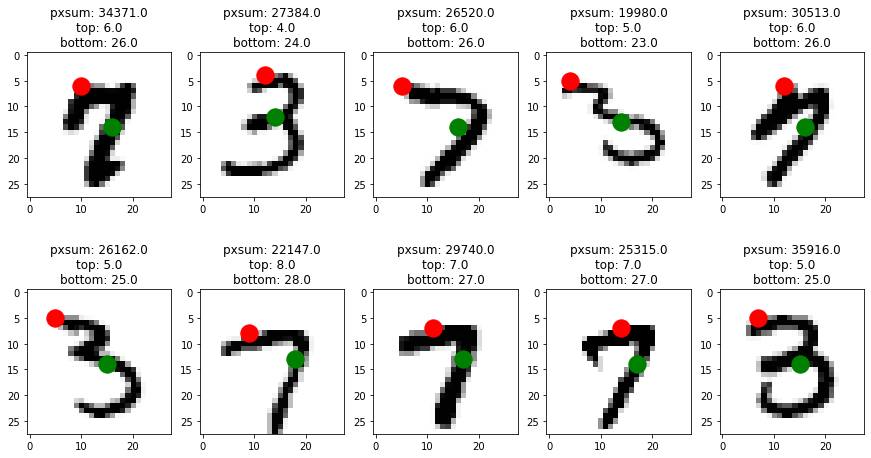

In [4]:
eda_fig_1(df, path)

In [5]:
y_p2 = torch.cat([_y for _x, _y in dl_2.train])
ys   = [y_p2[:,0], y_p2[:,1]]

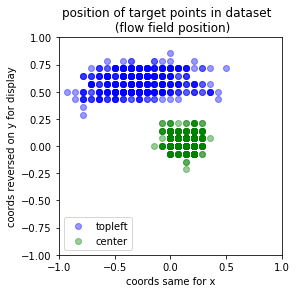

In [6]:
img_pt_plot(ys=ys,
           legend= ('topleft',  'center'))

### Fit Model - topleft
Uee 90 epochs to get a worthwhile model; only after ~30 epochs are we below baseline error

In [7]:
b_new_fit = False

history_fn = 'assets/pt3_topleft_3.csv'
model_fn   = 'pt3_topleft_2'

learn = cnn_learner(dl_1_topleft, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae, R2Score()],
                    cbs=CSVLogger(history_fn),
                    y_range=(-1.,1.),
                   )
if b_new_fit:
    set_seed(17)
    with learn.no_logging():
        learn.fine_tune(90)
    learn.save(model_fn)
    
if not(b_new_fit):
    learn.load(model_fn)

In [8]:
train_history = pd.read_csv(history_fn)
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,mae,r2_score,time
0,0,0.543690,0.092954,0.242163,-0.824727,00:09
1,1,0.532134,0.140789,0.303375,-1.763755,00:09


,epoch,train_loss,valid_loss,mae,r2_score,time
88,88,0.020841,0.021383,0.095315,0.580248,00:08
89,89,0.021200,0.021076,0.094615,0.586274,00:08


##### Build Baseline Error

In [9]:
y_train = torch.cat([_y for _x,_y in dl_1_topleft.train])
y_valid = torch.cat([_y for _x,_y in dl_1_topleft.valid])

mean_y = y_train.view(-1,2).mean(dim=0)
mean_y

tensor([-0.2896, -0.5890])

In [10]:
baseline_err = mse(torch.ones_like(y_valid) * mean_y, y_valid) 
baseline_err

tensor(0.0322)

##### Plot Training History

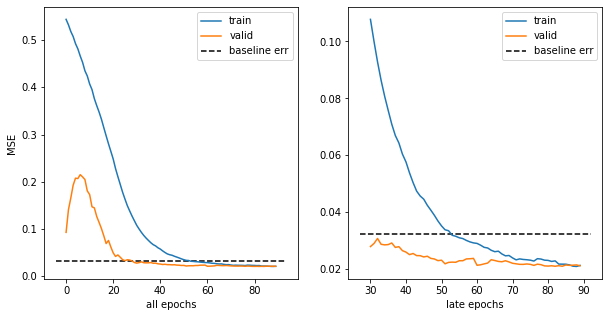

In [11]:
train_history_dualplot(train_history, 
                       fig2_startx=30, 
                       baseline_err=baseline_err,
                      )

### Fit Model - Target: center-point
This task is slighltly easier, and requires less epochs to beat the baseline error.

In [37]:
b_new_fit = False

history_fn = 'assets/pt3_center_1.csv'
model_fn   = 'pt3_center_2'

learn = cnn_learner(dl_1_center, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae, R2Score()],
                    cbs=CSVLogger(history_fn),
                    y_range=(-1.,1.),
                   )
if b_new_fit:
    
    set_seed(17)
    with learn.no_logging():
        learn.fine_tune(50)
        
    learn.save(model_fn)
    
if not(b_new_fit):
    
    learn.load(model_fn)

In [41]:
!ls assets

pt3_center_1.csv   pt3_topleft_2.csv  rm_1.csv	   rm_1_sc_saved.csv
pt3_topleft_1.csv  pt3_topleft_3.csv  rm_1_sc.csv  tmp.csv


In [42]:
!cat assets/pt3_center_1.csv

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.006819247268140316,0.061409495770931244,0.4138174095970345,00:00


In [38]:
train_history = pd.read_csv(history_fn)
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,mae,r2_score,time
0,0,0.006819,0.061409,0.413817,00:00,NaN


,epoch,train_loss,valid_loss,mae,r2_score,time
0,0,0.006819,0.061409,0.413817,00:00,NaN


In [39]:
y_train = torch.cat([_y for _x,_y in dl_1_center.train])
y_valid = torch.cat([_y for _x,_y in dl_1_center.valid])

mean_y = y_train.view(-1,2).mean(dim=0)
baseline_err = mse(torch.ones_like(y_valid) * mean_y, y_valid) 

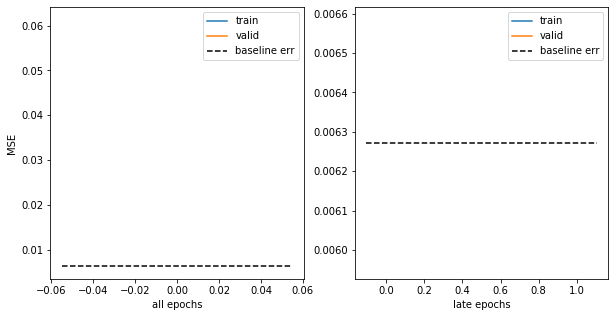

In [40]:
train_history_dualplot(train_history, 
                       fig2_startx=30, 
                       baseline_err=baseline_err,
                      )

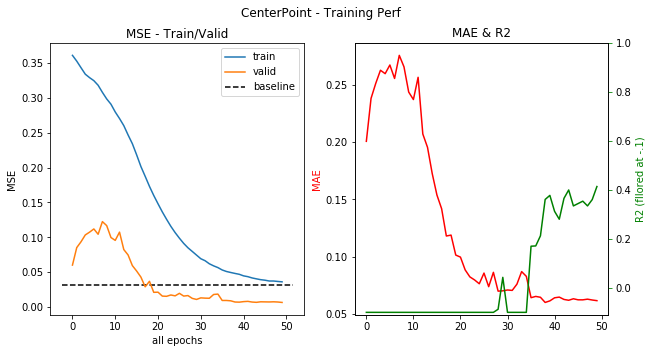

In [204]:
fig2_startx = 10

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(train_history['train_loss'])
ax[0].plot(train_history['valid_loss']);
ax[0].hlines(baseline_err, *ax[0].get_xlim(), linestyle='--')
ax[0].legend(['train','valid', 'baseline']);
ax[0].set_xlabel('all epochs')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE - Train/Valid')

# ax[1].plot(train_history['train_loss'][fig2_startx:])
# ax[1].plot(train_history['valid_loss'][fig2_startx:]);
# ax[1].hlines(baseline_err, *ax[1].get_xlim(), linestyle='--')
# ax[1].legend(['train','valid', 'baseline err']);

ax[1].plot(train_history['mae'], color='red')
ax[1].set_ylabel('MAE', color='red')
ax[1].set_title('MAE & R2')

y_r2 = [max(-.1, e) for e in train_history['r2_score']]
ax2 = ax[1].twinx()  
ax2.set_ylabel('R2 (fllored at -.1)', color='green')
ax2.plot(y_r2, color='green')
ax2.tick_params(axis='y', color='green')
ax2.set_ylim(-.11,1);


fig.suptitle('CenterPoint - Training Perf');

### Build Custom Arch
First we need to create a new datablock and dataloaders for the new architecture. This is because our current dataloaders were converted to 3-channel "colorized black and white" images when passed into cnn_learner with the pretrained flag set to True.

In the following, we'll continue to use the 1-channel, true "black and white" images as the input to our model.

In [63]:
# remake a datablock with BW-style images

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(y_names[2:]),
                  )

dls = dblock.dataloaders(df)

x, y = dls.one_batch()

x.shape

torch.Size([64, 1, 28, 28])

In [64]:
x_2 = x[:2]
x_2.shape

torch.Size([2, 1, 28, 28])

In [89]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )


out_net3 = net3(x_2)
out_net3.shape

torch.Size([2, 2])

##### Build Learner and Fit
Instead of using `cnn_learner` use the base class `Learner` with your custom arch and the 1-channel dataloader.

Even on the first epoch, it far outperfroms the 90th epoch perf of resnet18.

In [130]:
learn_net3 = Learner(dls, net3, loss_func=MSELossFlat(), )

In [131]:
learn_net3.fit(1)

epoch,train_loss,valid_loss,time
0,0.002717,0.002850,00:01


In [132]:
preds = learn_net3.get_preds()

##### Fit some more, it gets even better

In [135]:
learn_net3.fit(5)

epoch,train_loss,valid_loss,time
0,0.002329,0.001863,00:01
1,0.002064,0.002096,00:01
2,0.001883,0.001723,00:01
3,0.001732,0.001706,00:01
4,0.001634,0.001681,00:01


In [ ]:
def pva_plot(actuals, predcits, title=''):
    plt.scatter(actuals, predicts, alpha=0.4)
    y0, y1 = plt.ylim()
    x0, x1 = plt.xlim()
    full_area = [min(x0, y0), max(x1, y1)]
    plt.plot(full_area, full_area, linestyle='--')
    plt.xlabel('Actual'); plt.ylabel('Predicted');
    plt.title(f'{title} - Predicted vs Actual');

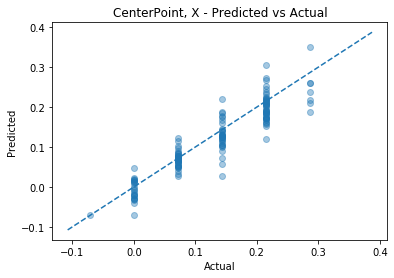

In [136]:
preds = learn_net3.get_preds()
actuals =  preds[1].view(-1,2)[:,0]
predicts = preds[0][:,0]

pva_plot(actuals, predicts, 'CenterPoint, X')

##### Compare ResNet to Net3
All Hail Net3! a new SOTA on MNIST ImagePoint Tasks

In [165]:
preds_resnet = learn.get_preds()
preds_net3    = learn_net3.get_preds()

In [166]:
mse(preds_net3[0], preds_net3[1])

tensor(0.0017)

In [167]:
mse(preds_resnet[0], preds_resnet[1])

tensor(0.0068)

##### Visualize Residuals of each model

In [185]:
resids_net3 =   (preds_net3[0] - preds_net3[1].view(-1,2))
resids_resnet = (preds_resnet[0] - preds_resnet[1].view(-1,2))

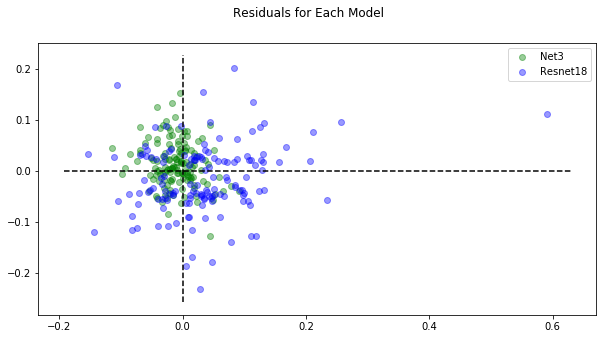

In [200]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(resids_net3[:,0], resids_net3[:,1], 
              c='green', alpha=0.4)
ax.scatter(resids_resnet[:,0], resids_resnet[:,1], 
              c='blue', alpha=0.4)
ax.legend(['Net3', 'Resnet18'])
ax.hlines(0, *ax.get_xlim(), linestyle='--')
ax.vlines(0, *ax.get_ylim(), linestyle='--')
fig.suptitle('Residuals for Each Model');

##### Replicate mse calcs

In [168]:
resids = (preds_net3[0] - preds_net3[1].view(-1,2))
resids[:3]

tensor([[-0.0239, -0.0834],
        [ 0.0394, -0.0262],
        [ 0.0236,  0.0286]])

In [169]:
resids_sq = resids**2
resids_sq[:3]

tensor([[0.0006, 0.0070],
        [0.0016, 0.0007],
        [0.0006, 0.0008]])

In [170]:
resids_sq.mean()

tensor(0.0017)